In [59]:
import numpy as np 
import pandas as pd 
import sys
import os
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
import matplotlib.pylab as plt
import warnings
from scipy.stats import skew, kurtosis
from datetime import datetime
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=10,20

# Add the grandparent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from Utils import FE_helper as FE
from Utils import training_models as TM
from tqdm import tqdm 
import json

# Importing Data

In [60]:
# 2. Load the data
train_df = pd.read_csv('../Original_Data/train_2025.csv') 
test_df = pd.read_csv('../Original_Data/test_2025.csv')

train_df = FE.add_features(train_df)
test_df = FE.add_features(test_df)

test_id = test_df['claim_number']
train_id = train_df['claim_number']
target = train_df['fraud']

ignore_var = ['claim_date.is_weekend', 'claim_date.near_holiday', 'fraud']
train_df = FE.drop_ignored_columns(train_df, ignore_var)
test_df = FE.drop_ignored_columns(test_df, ignore_var)


# Preprocessing Data. Training and Testing Data Needs To Be Fully Numerical Before Proceeding.

In [61]:
updated_train_df = train_df
updated_test_df = test_df

high_dim_cat_cols_to_drop = ['claim_date.day', 'claim_date.dayofweek', 'claim_date.weekofyear', 'claim_date.month']
updated_train_df.drop(columns = high_dim_cat_cols_to_drop, inplace=True, errors='ignore')
updated_test_df.drop(columns = high_dim_cat_cols_to_drop, inplace=True, errors='ignore')

# Step 1: Fit on training data
onehot, scaler, cat_cols, num_cols = FE.fit_regular_transformer(updated_train_df, '_count')

# Step 2: Transform training set itself
X_train_regular = FE.transform_regular_set(updated_train_df, onehot, scaler, cat_cols, num_cols)

# Step 3: Transform test set (call the same function on test_df)
X_test_regular = FE.transform_regular_set(updated_test_df, onehot, scaler, cat_cols, num_cols)


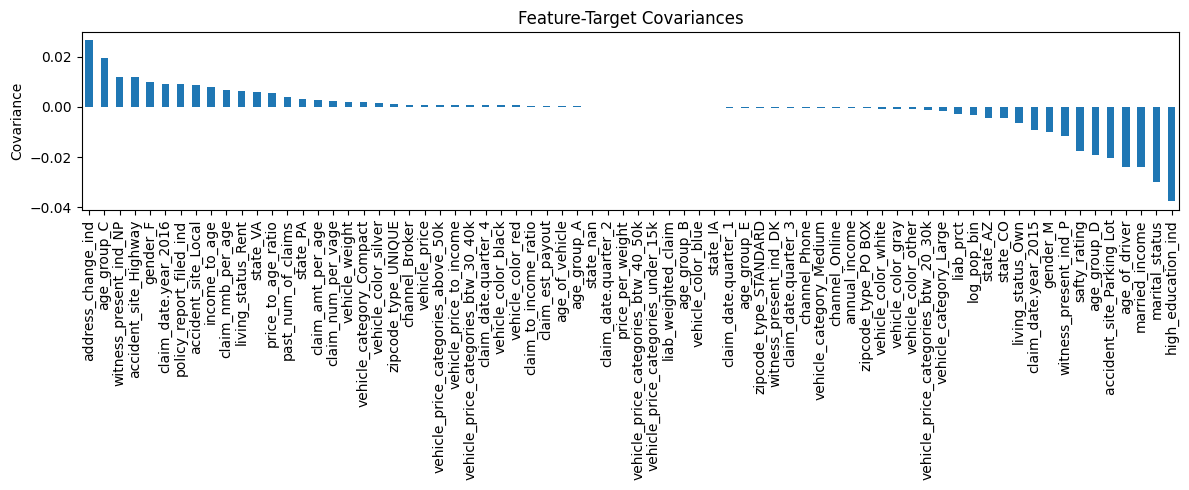

In [62]:
import seaborn as sns

cov_list = []

# Compute covariance between each feature and the target
for col in X_train_regular.columns:
    cov = np.cov(X_train_regular[col], target)[0, 1]
    cov_list.append(cov)

cov_df = pd.Series(cov_list, index=X_train_regular.columns)
cov_df.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5))
plt.title("Feature-Target Covariances")
plt.ylabel("Covariance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [63]:
cov_list

[-0.02378918307369699,
 -0.02977456847778655,
 -0.017600957532324955,
 -0.0005428850308669204,
 -0.03760990521265192,
 0.026413863383387786,
 0.004019293255192842,
 -0.002912143284570462,
 0.008981198948792546,
 0.00046914444757389424,
 0.0003290421304174603,
 0.0007886141935406947,
 0.00210766347835318,
 -0.003098744476938387,
 0.00048069478935086596,
 0.0006963126683003547,
 0.007899627468436336,
 0.0026662715934353456,
 0.006512413891089045,
 0.0023041608959207018,
 0.005691237997746566,
 6.0670043249082606e-05,
 -0.00014900322053656003,
 -0.02399855619906857,
 0.009814421788864804,
 -0.009814421788864804,
 -0.006384008988153659,
 0.006384008988153661,
 0.011848164404195312,
 0.008564426418751638,
 -0.02041259082294695,
 -0.0003825397707280035,
 0.011960269397682589,
 -0.011577729626954587,
 0.0009186683210795618,
 -0.0004893605200288882,
 -0.0004293078010506829,
 0.0019432684531856743,
 -0.0014809711650647123,
 -0.00046229728812093626,
 0.0005630930113401443,
 -0.000151810903074868

# Model Selection

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

def train_ridge_logreg(X_train, y_train, X_val, y_val, params, seed=None):
    
    imputer = SimpleImputer(strategy='mean')
    
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_train = pd.DataFrame(X_train, columns = X_train_regular.columns)
    X_val = pd.DataFrame(X_val, columns = X_train_regular.columns)
    
    # Fixed parameters for logistic regression
    lr_params_untrainable = {
        'penalty': 'l2',
        'solver': 'lbfgs',  # liblinear supports L1
        'random_state': seed if seed is not None else 42,
        'max_iter': 1000
    }
    params.update(lr_params_untrainable)

    # Train model
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)

    # Predict probabilities and tune threshold
    probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 200)
    f1s = [f1_score(y_val, probs > t) for t in thresholds]

    best_f1 = max(f1s)
    best_threshold = thresholds[np.argmax(f1s)]

    stats = {
        'f1': best_f1,
        'threshold': best_threshold,
        'iteration': None  # Not applicable to logistic regression
    }

    return probs, model, stats

def sample_lasso_logreg_hyperparams(trial):
    return {
        'C': trial.suggest_float('C', 1e-4, 10.0, log=True)  # Inverse of regularization strength
    }
    
def predict_logreg(model, test_df):
    return model.predict_proba(test_df)[:, 1]


In [68]:
cv_result, avg_probs, models_list = TM.run_cv_evaluation_single_model(X=X_train_regular, 
                                  y=target, 
                                  params={}, 
                                  train_model_fn=train_ridge_logreg, 
                                  kfoldcv=20,
                                  test_df=X_test_regular,
                                  predict_fn=predict_logreg,
                                  seed=42)